# Preprocess

In [ ]:
import pandas as pd
import numpy as np
import os
import datetime

In [ ]:
h_df = pd.read_csv('household.csv')
p_df = pd.read_csv('person.csv')
t_df = pd.read_csv('trip.csv')

In [ ]:
household_df = h_df[
    ['HOUSEHOLD_ID', 'HOME_TYPE', 'HOME_OWNERSHIP',
    'HHSIZE','NUMSTUDENTS', 'NUMDRIVERS', 'NUMWORKERS',
    'NUMDISABILITIES', 'NUMVEHICLE', 'HH_INCOME_DETAILED']]

person_df = p_df[['HOUSEHOLD_ID', 'PERSON_ID', 'AGE','GENDER',
             'LICENSE', 'DISABILITY', 'EMPLOYMENT_STATUS',
             'JOBS_COUNT','J1_WORKPLACE_LOC', 'J1_COMMUTE_FREQ',
              'J1_COMMUTE_MODE','J1_TELECOMMUTE','STUDENT_STATUS',
              'SCHOOL_TYPE', 'SCHOOL_FREQ', 'SCHOOL_MODE',
              'TD_TELECOMMUTE_TIME','TD_SHOP_TIME', 'PERSON_TRIPCOUNT',
              'TRIPS_YESNO',
            ]]
              
trip_df = t_df[['HOUSEHOLD_ID', 'PERSON_ID','TRIPNO', 'O_PURPOSE',
       'O_ACTIVITY','D_PURPOSE', 'D_ACTIVITY','DEPARTURE_TIME_HHMM',
        'ARRIVAL_TIME_HHMM', 'REPORTED_TRAVEL_TIME']]

In [ ]:
from datetime import timedelta


def keep_columns(df, column_list=[]):
    """
    keep needed columns

    Parameters
    ----------
    df : dataframe
        this can be either trip or person dataframe.
    column_list : list
        this is a list of columns we want to keep

    Returns
    -------
    a dataframe with desired columns only.

    """
    new_df = df[column_list]
    return new_df


trip_cols = ['STRTTIME', 'ENDTIME', 'TRVLCMIN', 'WHYFROM', 'WHYTO', 'DWELTIME']


def make_intervals(intervel_lenght=5):
    """
    make custom minutes time intervals for 24 hours

    Returns
    -------
    a list of tuples containing custom minutes time intervals.

    """
    # this cell makes a list and a tuple form of time
    # intervals i.e (1100, 1115)

    n_intervals = (24 * 60) / intervel_lenght
    n_intervals = int(n_intervals)   # to prevent error in for loop

    # first make time points from 0 - 2359
    time_points = []
    hour = 0
    minute = 0
    for i in range(0, (n_intervals + 1)):
        if minute < 60:
            time = hour + minute
            time_points.append(time)
        else:
            minute = 0
            hour += 100
            time = hour + minute
            time_points.append(time)
        minute += intervel_lenght
    time_points[n_intervals] = 2359

    p = 0
    time_intervals = []
    for item in time_points:
        try:
            x = tuple((time_points[p], time_points[p + 1]))
            time_intervals.append(x)
            p += 1
        except:
            pass

    return time_intervals

# this function is useful because we need to first break dweltime or traveltime
# into pieces so that they could be seen in other time intervals


def break_period(period, intervel_lenght=5):
    """
    this function takes dwel time or travel time 
    and breaks it into 15 minutes periods and makes a 
    list of it. the remainder is also added at the end of the list

    Parameters
    ----------
    period : int
        DESCRIPTION.

    Returns
    -------
    broken_into_intervals : list
        a list of entry time into desired broken periods.

    """
    broken_into_intervals = []
    # in cases that the period is not given we return an empty list
    if period == -9 or period == 0:
        broken_into_intervals.append(0)
    else:
        tedad_15min = period // intervel_lenght
        baghi_15min = period % intervel_lenght

        for i in range(tedad_15min):
            broken_into_intervals.append(intervel_lenght)

        if baghi_15min == 0:
            pass
        else:
            broken_into_intervals.append(baghi_15min)

    return broken_into_intervals


# after this function the time can be easily added and retain its militay format at the same time
def time_adder(time, added_minute):
    """
    this function takes anytime in military as the first argument
    and adds the second argument given as minutes to it and returns the 
    added time

    Parameters
    ----------
    time : int
        time in millitary format.
    added_minute : int
        number of minutes we want to add.

    Returns
    -------
    time_f : int
        time in millitary, after the number of minutes are added to it.

    """
    min_number_60 = added_minute // 60
    min_remainder_60 = added_minute % 60

    time_str = str(time)
    if len(time_str) == 1:
        minute = int(time_str)
        hour = 0
    elif len(time_str) == 2:
        minute = int(time_str)
        hour = 0
    elif len(time_str) == 3:
        minute = int(time_str[1:3])
        hour = int(time_str[0:1] + '00')
    elif len(time_str) == 4:
        minute = int(time_str[2:4])
        hour = int(time_str[0:2] + '00')

    for x in range(min_number_60):
        hour += 100
        if hour > 2359:
            hour = 0

    minute = minute + min_remainder_60
    if minute < 60:
        time_f = hour + minute
    if minute == 60:
        minute = 0
        hour += 100
        if hour > 2359:
            hour = 0
        time_f = hour + minute
    elif minute > 60:
        minute = minute - 60
        hour += 100
        if hour > 2359:
            hour = 0
        time_f = hour + minute
    return time_f


def time_subtracter(time2, time1):
    """
    get two time intervals in military formate and subtract them
    time 2 has to be higher than time 1 in value
    Parameters
    ----------
    time1 : TYPE
        DESCRIPTION.
    time2 : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    if time2 > time1:
        time1_h = time1 // 100
        time2_h = time2 // 100

        time1_m = time1 % 100
        time2_m = time2 % 100

        t1 = timedelta(hours=time1_h, minutes=time1_m)
        t2 = timedelta(hours=time2_h, minutes=time2_m)

        difference = t2 - t1

        x = str(timedelta(seconds=difference.seconds))
        list_time = x.split(":")
        difference = int(list_time[0]) * 60 + int(list_time[1])

        return difference


def apply_time_add(str_end_time, trvl_dwl_time, intervel_lenght):
    """
    this function takes the start time or the end time as
    the first argument and takes travel time or dwel time as 
    the latter. After travel time or dwel time are broken into
    custom minutes intervals, they are added to the first argument 
    and a list is returned entailing these added times

    Parameters
    ----------
    str_end_time : int (military time format)
        DESCRIPTION.
    trvl_dwl_time : int (number of minutes)
        DESCRIPTION.

    Returns
    -------
    list_travel_time : list
        DESCRIPTION.

    """

    list_travel_time = []
    time_divided_by_interval = break_period(trvl_dwl_time, intervel_lenght=intervel_lenght)
    x = str_end_time
    for i in time_divided_by_interval:
        x = time_adder(x, i)
        list_travel_time.append(x)

    return list_travel_time


def make_interval_dict(intervel_lenght=5):
    """
    make dictionary of intervals as keys and 0 as values

    Parameters
    ----------
    intervel_lenght : TYPE, optional
        DESCRIPTION. The default is 5.

    Returns
    -------
    None.

    """
    # make intervals (defaul=5)
    time_intervals = make_intervals(intervel_lenght=intervel_lenght)

    n_intervals = (24 * 60) / intervel_lenght
    n_intervals = int(n_intervals)

    # initiate an empty list of dictionaries
    intrvl_dict_lst = list()
    for i in range(n_intervals):
        intrvl_dict_lst.append('0')

    # a dict of intervals as keys with empty values
    values = intrvl_dict_lst
    keys = time_intervals
    dict_time = dict(zip(keys, values))
    
    return dict_time
    
def person_day_activity(starttime, traveltime, endtime,
                        dweltime, whyfrom, whyto,
                        dict_time, intervel_lenght):
    """
    update a time interval dictionary based on activities

    Parameters
    ----------
    starttime : TYPE
        DESCRIPTION.
    traveltime : TYPE
        DESCRIPTION.
    endtime : TYPE
        DESCRIPTION.
    dweltime : TYPE
        DESCRIPTION.
    whyfrom : TYPE
        DESCRIPTION.
    whyto                        
        DESCRIPTION.
        
    dict_time : TYPE

    Returns
    -------
    dict_time : TYPE
        DESCRIPTION.

    """

    # break dwel and travel time into your interval_lenth period
    lst_broken_trvl_time = apply_time_add(starttime, traveltime, intervel_lenght)
    lst_broken_dwel_time = apply_time_add(endtime, dweltime, intervel_lenght)

    v = -1
    # loop through the time intervals
    for timeinterval in dict_time.keys():
        v += 1
        # check if the start time is in the interval
        if starttime in range(timeinterval[0], timeinterval[1]):
            dict_time[timeinterval] = str(whyfrom)

        # to put driving or on travel in the periods
        for x in lst_broken_trvl_time:
            # if the person is driving or is on travel in the interval, add this fact to the dict
            if x in range(timeinterval[0], timeinterval[1]):
                # only if the time period is not occupied
                if dict_time[timeinterval] == '0':
                    dict_time[timeinterval] = str(100)

        # to put dwel time in the right intervals
        for i in lst_broken_dwel_time:
            if i in range(timeinterval[0], timeinterval[1]):
                dict_time[timeinterval] = str(whyto)


        # check if the end time is in the interval
        if endtime in range(timeinterval[0], timeinterval[1]):
                dict_time[timeinterval] = str(whyto)

    return dict_time

def person_day_activity_iterate(STRTTIME_agg, TRVLCMIN_agg, ENDTIME_agg, WHYFROM_agg, WHYTO_agg, DWELTIME_agg, intervel_lenght):
    
    list_lacking_data = [-1, -7, -8, -9]   
        
    # numbers has be changed to int so that the previous function can run it 
    list_STRTTIME_agg = [int(i) for i in STRTTIME_agg.split(",")]
    list_TRVLCMIN_agg = [int(i) for i in TRVLCMIN_agg.split(",")]
    list_ENDTIME_agg = [int(i) for i in ENDTIME_agg.split(",")]
    list_WHYFROM_agg = [int(i) for i in WHYFROM_agg.split(",")]
    list_WHYTO_agg = [int(i) for i in WHYTO_agg.split(",")]
    list_DWELTIME_agg = [int(i) for i in DWELTIME_agg.split(",")]
    
    a = any(x in list_lacking_data for x in list_STRTTIME_agg)
    b = any(x in list_lacking_data for x in list_TRVLCMIN_agg)
    c = any(x in list_lacking_data for x in list_ENDTIME_agg)
    d = any(x in list_lacking_data for x in list_WHYFROM_agg)
    e = any(x in list_lacking_data for x in list_WHYTO_agg)
    f = any(x in list_lacking_data for x in list_DWELTIME_agg[0:(len(list_DWELTIME_agg)-1)])

    if (a == True) or (b == True) or (c == True) or (d == True) or (e == True) or (f == True):
        return 'NA'
    else:
        n = 0
        dict_update = make_interval_dict(intervel_lenght=intervel_lenght)
        
        # choose on of the items from trips to loop over
        # there is no difference so I chose starttime
        for starttime in list_STRTTIME_agg:
            
            dict_update = person_day_activity(
                list_STRTTIME_agg[n], list_TRVLCMIN_agg[n],
                list_ENDTIME_agg[n], list_DWELTIME_agg[n],
                list_WHYFROM_agg[n], list_WHYTO_agg[n]
                , dict_update, intervel_lenght)
            n +=1

        final_string_list =  list(dict_update.values())
        final_string = ",".join(final_string_list)
        
        return final_string

In [ ]:
# defining 3 columns that shows the number of trips by category
counts = trip_df.groupby(['HOUSEHOLD_ID', 'PERSON_ID', "D_ACTIVITY"]).apply(len).unstack(fill_value=0)
counts.columns = counts.columns.map(lambda x: f"activity_{x}")
person_df = person_df.merge(counts, how="left", left_on=['HOUSEHOLD_ID', 'PERSON_ID'], right_index=True).fillna(0)

In [ ]:
# defining 3 columns that shows the number of trips by category
count2 = trip_df.groupby(['HOUSEHOLD_ID', 'PERSON_ID', "D_PURPOSE"]).apply(len).unstack(fill_value=0)
count2.columns = count2.columns.map(lambda x: f"pupose_{x}")
person_df = person_df.merge(count2, how="left", left_on=['HOUSEHOLD_ID', 'PERSON_ID'], right_index=True).fillna(0)

In [ ]:
# add the data from the hosehold file for each person
person_df = pd.merge(person_df, household_df, on='HOUSEHOLD_ID', how='left')

trip_df[['DEPARTURE_TIME_HHMM', 'ARRIVAL_TIME_HHMM']] = trip_df[['DEPARTURE_TIME_HHMM', 'ARRIVAL_TIME_HHMM']].replace({':':''}, regex=True).astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
def cal_dwl(df):
    # Create dweltime column
    # create dwel time
    def get_minutes(s):
        return s//100 * 60 + s % 100
        
    df['DWELTIME'] = (get_minutes(df.DEPARTURE_TIME_HHMM)	
                        .groupby([df.HOUSEHOLD_ID, df.PERSON_ID])
                        .shift(-1)
                        .sub(get_minutes(df.ARRIVAL_TIME_HHMM)).fillna(0)
                    )
    return df['DWELTIME'].astype(int)

trip_df['DWELTIME'] = cal_dwl(trip_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
trip_df.rename(columns={'HOUSEHOLD_ID':'HOUSEID', 'PERSON_ID':'PERSONID', 'REPORTED_TRAVEL_TIME':'TRVLCMIN',
            'D_ACTIVITY':'WHYTO', 'O_ACTIVITY':'WHYFROM', 'ARRIVAL_TIME_HHMM':'ENDTIME'
            , 'DEPARTURE_TIME_HHMM':'STRTTIME'}, inplace=True)

person_df.rename(columns={'HOUSEHOLD_ID':'HOUSEID', 'PERSON_ID':'PERSONID'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# changing the type of numbers to string so that we can put them together as a string
trip_df[
    ['STRTTIME', 'ENDTIME', 'TRVLCMIN',
     'WHYFROM', 'WHYTO', 'DWELTIME']
] = trip_df[
    ['STRTTIME', 'ENDTIME', 'TRVLCMIN',
     'WHYFROM', 'WHYTO', 'DWELTIME']
].astype('str')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# putting all of a persons trip information in a row
trip_df_summed = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['STRTTIME']
    .agg(','.join).reset_index(name='STRTTIME_agg')
)
trip_df_summed1 = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['TRVLCMIN']
    .agg(','.join).reset_index(name='TRVLCMIN_agg')
)
trip_df_summed2 = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['ENDTIME']
    .agg(','.join).reset_index(name='ENDTIME_agg')
)
trip_df_summed3 = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['WHYFROM']
    .agg(','.join).reset_index(name='WHYFROM_agg')
)
trip_df_summed4 = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['WHYTO']
    .agg(','.join).reset_index(name='WHYTO_agg')
)
trip_df_summed5 = (
    trip_df.groupby([trip_df['HOUSEID'], trip_df['PERSONID']])['DWELTIME']
    .agg(','.join).reset_index(name='DWELTIME_agg')
)

In [ ]:
# merging aggregated columns to construct a unit dataframe
df_merge_col = pd.merge(trip_df_summed, trip_df_summed1,
                        on=['HOUSEID', 'PERSONID'])
df_merge_col = pd.merge(df_merge_col, trip_df_summed2,
                        on=['HOUSEID', 'PERSONID'])
df_merge_col = pd.merge(df_merge_col, trip_df_summed3,
                        on=['HOUSEID', 'PERSONID'])
df_merge_col = pd.merge(df_merge_col, trip_df_summed4,
                        on=['HOUSEID', 'PERSONID'])
df_merge_col = pd.merge(df_merge_col, trip_df_summed5,
                        on=['HOUSEID', 'PERSONID'])

In [ ]:
# this should take a few minutes
df_merge_col['day_activities_5'] = ''
df_merge_col['day_activities_5'] = df_merge_col.apply(
    lambda row: person_day_activity_iterate(
        row['STRTTIME_agg'], row['TRVLCMIN_agg'], row['ENDTIME_agg'],
        row['WHYFROM_agg'], row['WHYTO_agg'], row['DWELTIME_agg'], 5
    ), axis=1
)

df_merge_col['day_activities_15'] = ''
df_merge_col['day_activities_15'] = df_merge_col.apply(
    lambda row: person_day_activity_iterate(
        row['STRTTIME_agg'], row['TRVLCMIN_agg'], row['ENDTIME_agg'],
        row['WHYFROM_agg'], row['WHYTO_agg'], row['DWELTIME_agg'], 15
    ), axis=1
)

In [ ]:
df_merge_col

,HOUSEID,PERSONID,STRTTIME_agg,TRVLCMIN_agg,ENDTIME_agg,WHYFROM_agg,WHYTO_agg,DWELTIME_agg,day_activities_5,day_activities_15
0,140000271,14000027101,"915,1126,1220,1232,1654","10,4,8,8,21","925,1130,1228,1240,1715","1,2,5,5,2","2,5,5,2,1","121,50,4,254,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1,140000271,14000027103,"740,1700","16,25","756,1725","1,2","2,1","544,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,140000280,14000028001,"545,1330,1745,1820,1955","20,15,15,27,35","605,1345,1800,1847,2030","1,2,1,5,13","2,1,5,13,1","445,240,20,68,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
3,140000284,14000028401,"945,1125,1307,1335,1431","20,31,20,19,15","1005,1156,1327,1354,1446","13,13,5,10,5","13,5,10,5,1","80,71,8,37,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
4,140000291,14000029101,"535,1445,1550","20,10,25","555,1455,1615","1,2,9","2,9,1","530,55,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,..."
...,...,...,...,...,...,...,...,...,...,...
32918,180256936,18025693601,"925,1210,1825,2130,2140","10,10,35,5,35","935,1220,1900,2135,2215","1,11,1,15,5","11,1,15,5,1","155,365,150,5,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
32919,180256940,18025694001,"1050,1120,1145,1205,1210","15,5,10,5,10","1105,1125,1155,1210,1220","1,5,5,5,18","5,5,5,18,1","15,20,10,0,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
32920,180256940,18025694002,"900,1110,1150,1620,1655","40,30,10,10,10","940,1140,1200,1630,1705","1,9,10,1,5","9,10,1,5,1","90,10,260,25,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
32921,180256941,18025694101,"1815,2000","35,35","1850,2035","1,7","7,1","70,0","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [ ]:
df_merge_col.day_activities_5[0]

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,100,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,100,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,100,100,100,100,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0'

In [ ]:
df_merge_col.day_activities_15[0]

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,5,5,5,5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,100,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0'

In [ ]:
remove_column = [
    'STRTTIME_agg', 'TRVLCMIN_agg', 'ENDTIME_agg',
    'WHYFROM_agg', 'WHYTO_agg', 'DWELTIME_agg'
]
df_merge_col.drop(remove_column, axis=1, inplace=True)


In [ ]:
# purp_dict = {1: 'home',
#     2:	'Work', 3:	'Work-related', 4:	'Shop',
#     7:	'Daycare', 8:	'School', 9:	'Other',
#     11:	'Drop Off/Pick Up Someone', 13:	'Parking Point',
#     16:	'Inter-City Rail Terminal', 17:	'Inter-City Bus Terminal',
#     18:	'Airport', 77:	'Gas/EV Charging Station',
#     99:	'External Point', -9:	'Not ascertained'}

# act_dic = {'1':	'Home',
# '2':	'Work', '3':	'Volunteer', '4':	'School',
# '5':	'Shopping', '6':	'Meal (quick-stop)',
# '7':	'Meal', '8':	'Gas', '9':	'Health care',
# '10':	'Non-shopping errand', '11':	'Socialize',
# '12':	'Civic/Religious', '13':	'Exercise',
# '14':	'Recreation', '15':	'Entertainment',
# '16':	'Drop off/pick up', '18':	'Other',
# '-9':	'Not ascertained', '100':'Traveling', '0':'Home'}

In [ ]:
# to prevet incorrect replace ment first replace 2 or more chars and then replace numbers with 1 character
act_dic_1 = {'11':	'socialize',
'12':	'civicorreligious', '13':	'exercise',
'14':	'recreation', '15':	'entertainment',
'16':	'dropofforpick up', '18':	'otheractivities',
'-9':	'notascertainedactivity', '100':'driving'}

act_dic_2 = {'1':	'home',
'2':	'work', '3':	'volunteerwork', '4':	'schooloreducation',
'5':	'shopping', '6':	'mealquickstop',
'7':	'meal', '8':	'gas', '9':	'healthcare',
'10':	'nonshoppingerrand'}

act_dic_3 = {',':' ','0':'home'} #we assume zeros are home

In [ ]:
df_merge_col['day_activities_5_text'] = df_merge_col['day_activities_5'].replace(act_dic_1, regex=True).replace(act_dic_2, regex=True).replace(act_dic_3, regex=True).str.strip()

df_merge_col['day_activities_15_text'] = df_merge_col['day_activities_15'].replace(act_dic_1, regex=True).replace(act_dic_2, regex=True).replace(act_dic_3, regex=True).str.strip()

In [ ]:
person_df = pd.merge(person_df, df_merge_col, on=['HOUSEID', 'PERSONID'])
person_df.replace('NA', np.nan, inplace=True)
person_df.dropna(inplace=True)
person_df.reset_index(drop=True, inplace=True)

In [ ]:
def age_bucket(age):
    if age <= 18:
        age_group = '18 and younger'
    elif age>18 and age<35:
        age_group ='18 to 35'
    elif age>=35 and age<60:
        age_group ='35 to 60'
    elif age>=60:
        age_group = '60 and older'
    return age_group
  
person_df['AGE'] = person_df.AGE.apply(age_bucket)

In [ ]:
def income_bucket(income):
    if income == 1 or income ==2 or income ==3 or income ==4:
        income_group = 'less than 50000$'
    elif income == 5 or income == 6:
        income_group = '50,000$ to 100,000$'
    else:
        income_group = '100,000$ to 150,000'
    return income_group
    
person_df['income'] = person_df.HH_INCOME_DETAILED.apply(income_bucket)

In [ ]:
employment_dict = {0	:'Worker, including self employed',
	1	:'Retired',
	2	:'Volunteer',
	3	:'Homemaker',
	4	:'Unemployed but looking for work',
	5	:'Unemployed, not seeking employment',
	6	:'Student (part-time or full-time)',
	7	:'Disabled non-worker'}


person_df['EMPLOYMENT_STATUS'] = person_df['EMPLOYMENT_STATUS'].replace(employment_dict)

In [ ]:
person_df['has_more_than_one_job'] = person_df.JOBS_COUNT.apply(lambda x: 1 if x> 1 else 0)

In [ ]:
person_df['J1_TELECOMMUTE'] = person_df['J1_TELECOMMUTE'].replace(-9, 0)
person_df['J1_TELECOMMUTE'] = person_df['J1_TELECOMMUTE'].replace(2, 0)

In [ ]:
#pd.set_option('display.max.columns', None)

In [ ]:
remove_column = ['LICENSE', 'J1_WORKPLACE_LOC','J1_COMMUTE_MODE', 'J1_COMMUTE_FREQ', 'SCHOOL_TYPE',
 'SCHOOL_FREQ', 'SCHOOL_MODE', 'TD_TELECOMMUTE_TIME', 'TD_SHOP_TIME',
 'PERSON_TRIPCOUNT', 'TRIPS_YESNO', 'HOME_TYPE', 'HOME_OWNERSHIP',
 'HHSIZE', 'NUMSTUDENTS','NUMDRIVERS', 'NUMWORKERS', 'NUMDISABILITIES',
 'NUMVEHICLE', 'JOBS_COUNT', 'DISABILITY', 'activity_-9', 'pupose_-9', 'HH_INCOME_DETAILED',
 'day_activities_5', 'day_activities_15', 'HOUSEID', 'PERSONID']
 
person_df.drop(remove_column, axis=1, inplace=True)

In [ ]:
person_df = person_df.replace(-9, np.nan)
person_df.dropna(inplace=True)

person_df = pd.get_dummies(data=person_df, columns=['income', 'AGE', 'EMPLOYMENT_STATUS'])

In [ ]:
person_df['GENDER'] = person_df['GENDER'].replace(2, 0) # 1 is female
person_df

,GENDER,J1_TELECOMMUTE,STUDENT_STATUS,activity_1,activity_2,activity_3,activity_4,activity_5,activity_6,activity_7,...,AGE_35 to 60,AGE_60 and older,EMPLOYMENT_STATUS_Disabled non-worker,EMPLOYMENT_STATUS_Homemaker,EMPLOYMENT_STATUS_Retired,EMPLOYMENT_STATUS_Student (part-time or full-time),EMPLOYMENT_STATUS_Unemployed but looking for work,"EMPLOYMENT_STATUS_Unemployed, not seeking employment",EMPLOYMENT_STATUS_Volunteer,"EMPLOYMENT_STATUS_Worker, including self employed"
0,1.0,1,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0.0,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
4,1.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32903,0.0,0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
32904,1.0,0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
32905,0.0,0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
32906,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
person_df.to_csv('./preprocced_data_home.csv')

# word2vec

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import pandas as pd
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import joblib

In [ ]:
!pip install --upgrade gensim
import gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
def read_data(path="./preprocced_data_home.csv"):
    data = pd.read_csv(path)
    data = data[['day_activities_5_text', 'day_activities_15_text']]
    return data

In [ ]:
def drop_duplicate_activity(en_string):
    n=1
    list_words = en_string.split(' ')
    new_string_list = []

    for word in list_words:
        try:
            if list_words[n-1] != list_words[n]:
                new_string_list.append(word)
            else:
                pass
            n += 1
        except:
            new_string_list.append(word)
    out_string = " ".join(new_string_list)
    return out_string    

In [ ]:
data = read_data()
test_string = data.day_activities_5_text[0]
#print(test_string)
print(drop_duplicate_activity(test_string))

home driving work shopping driving work driving home


In [ ]:
def data_cleaning(df, text_column):
    data_lines = list()
    df[text_column] = df[text_column].apply(drop_duplicate_activity)
    lines = df[text_column].values.tolist()

    for line in lines:
        # tokenize the text
        tokens = word_tokenize(line)
        tokens = [w.lower() for w in tokens]
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        data_lines.append(words)

    return data_lines

## *Custom word2vec model for 5 and 15 min intervals*

In [ ]:
def word2vec(data_lines, save_name, vector_size=100, window=30):
    """Save the word2ve model as a python dictionary"""
    model = gensim.models.Word2Vec(sentences=data_lines, vector_size=vector_size, window=window, workers=4, min_count=1, sg=1) #sg= 1:skip-gram 0:cbow

    filename = f"./{save_name}.txt"
    model.wv.save_word2vec_format(filename, binary=False)

    embedding_index = {}
    f = open(os.path.join('', f"./{save_name}.txt"),  encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeff
    f.close()
    joblib.dump(embedding_index, f'./{save_name}.pkl')
    
    return None

In [ ]:
def create_word2vec():
    data = read_data("./preprocced_data_home.csv")
    data_lines5 = data_cleaning(df=data, text_column='day_activities_5_text')
    word2vec(data_lines=data_lines5, save_name='day_activities_5_text',vector_size=20, window=5)

    data_lines15 = data_cleaning(df=data, text_column='day_activities_15_text')
    word2vec(data_lines=data_lines15, save_name='day_activities_15_text', vector_size=20, window=3)
    return None

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np

In [ ]:
create_word2vec()

In [ ]:
import os
from time import time

import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops


from tensorflow.python.keras.layers import Input, Dense, Multiply, Activation
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
import nltk
from collections import Counter
import joblib

In [ ]:
# -*- coding: utf-8 -*-

import os
from collections import Counter
import nltk
import numpy as np
import scipy.io
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from gensim.models import KeyedVectors


def metaembedding_load_stackoverflow(data_path='./data/stackoverflow/'):

    # load w2v embedding
    with open(data_path + 'vocab_withIdx.dic', 'r') as inp_indx, \
            open(data_path + 'vocab_emb_Word2vec_48_index.dic', 'r') as inp_dic, \
            open(data_path + 'vocab_emb_Word2vec_48.vec') as inp_vec:
        pair_dic = inp_indx.readlines()
        word_index = {}
        for pair in pair_dic:
            word, index = pair.replace('\n', '').split('\t')
            word_index[word] = index

        index_word = {v: k for k, v in word_index.items()}

        emb_index = inp_dic.readlines()
        emb_vec = inp_vec.readlines()
        word_vectors = {}

        for index, vec in zip(emb_index, emb_vec):
            word = index_word[index.replace('\n', '')]
            word_vectors[word] = np.array(list((map(float, vec.split()))))

    with open(data_path + 'title_StackOverflow.txt', 'r') as inp_txt:
        all_lines = inp_txt.readlines()
        text_file = " ".join([" ".join(nltk.word_tokenize(c)) for c in all_lines])
        word_count = Counter(text_file.split())
        total_count = sum(word_count.values())
        unigram = {}
        for item in word_count.items():
            unigram[item[0]] = item[1] / total_count

        all_vector_representation = np.zeros(shape=(20000, 48))
        original_all_vector_repre = np.zeros(shape=(20000, 48))

        for i, line in enumerate(all_lines):
            word_sentence = nltk.word_tokenize(line)
            sent_rep = np.zeros(shape=[48, ])
            original_sent_rep = np.zeros(shape=[48, ])
            j = 0
            for word in word_sentence:
                try:
                    wv = word_vectors[word]
                    j = j + 1
                except KeyError:
                    continue
                weight = 0.1 / (0.1 + unigram[word])
                sent_rep += wv * weight
                original_sent_rep += wv
            if j != 0:
                all_vector_representation[i] = sent_rep / j
                original_all_vector_repre[i] = original_sent_rep / j
            else:
                all_vector_representation[i] = sent_rep
                original_all_vector_repre[i] = original_sent_rep
    pca = PCA(n_components=1)
    pca.fit(all_vector_representation)
    pca = pca.components_
    XX1 = all_vector_representation - all_vector_representation.dot(pca.transpose()) * pca

    XX = XX1
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(XX)

    with open(data_path + 'label_StackOverflow.txt') as label_file:
        y = np.array(list((map(int, label_file.readlines()))))
    x_1 = XX
    y_1 = y

    del scaler

    #############################################################
    #  GOOGLENEWS WORD2VECTOR  it can be used in some datasets
    googlew2vmodel = KeyedVectors.load_word2vec_format('./w2vmodel/GoogleNews-vectors-negative300.bin', binary=True)
    sentvectors2 = np.zeros(shape=(20000, 300))
    for i, line in enumerate(all_lines):
        word_sentence = nltk.word_tokenize(line)
        sent_rep = np.zeros(shape=[300, ])
        j = 0
        for word in word_sentence:
            try:
                wv = googlew2vmodel[word]
                j = j + 1
            except KeyError:
                continue
            sent_rep += wv
        if j != 0:
            sentvectors2[i] = sent_rep / j
        else:
            sentvectors2[i] = sent_rep
    
    scaler2 = MinMaxScaler()
    XX2 = scaler2.fit_transform(sentvectors2)
    x_2 = XX2

    #############################################################
    #  SBERT  load sbert embedding, the sbert embedding is obtained in other program and saved to npy
    
    stackoverflow_sbert = np.load(data_path+'stackoverflow.npy')
    scaler4 = MinMaxScaler()
    XX4 = scaler4.fit_transform(stackoverflow_sbert)
    x_4 = XX4
    del scaler4

    #############################################################
    # combine different embeddings

    XXconcat = np.concatenate([x_1,stackoverflow_sbert],axis=1)
    x_1_pad = np.pad(x_1,((0,0),(0,720)),'constant',constant_values=(0,0))
    XXavg = (x_1_pad + stackoverflow_sbert)/2
    XXsvd = PCA(n_components=500).fit_transform(XXconcat)
    return XXconcat , y


def load_data(dataset_name):
    print('load data')
    return metaembedding_load_stackoverflow()

In [ ]:
import os
from collections import Counter
import nltk
import numpy as np
import pandas as pd
import scipy.io
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from gensim.models import KeyedVectors

In [ ]:
def Att(att_dim,inputs,name):
    V = inputs
    QK = Dense(att_dim, use_bias=False)(inputs)
    QK = Activation("softmax",name=name)(QK)
    MV = Multiply()([V, QK])
    return(MV)


def selfattoptions(args):
    q = args[0]
    k = args[1]
    v = args[2]

    q = tf.expand_dims(q,-1)
    k = tf.expand_dims(k,-1)
    v = tf.expand_dims(v,-1)
    
    QK = K.batch_dot(q, K.permute_dimensions(k,[0,2,1]))
    QK = QK /(20**0.5) 
    QK = K.softmax(QK)
    MV = K.batch_dot(QK,v) 
    MV = tf.squeeze(MV,-1)
    return MV


def SelfAtt(att_dim,inputs,name,i):

    Qq = Dense(att_dim, use_bias=False)(inputs)
    Kk = Dense(att_dim, use_bias=False)(inputs)
    Vv = Dense(att_dim, use_bias=False)(inputs)
    res = tf.keras.layers.Lambda(selfattoptions, name = 'attentionvecop_%d' % i)([Qq, Kk, Vv])
    MV = res
    
    return(MV)
    
def autoencoder(dims, act=tf.nn.leaky_relu, init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    x = tf.keras.layers.Input(shape=(dims[0],), name='input')
    h = x

    # encoder
    for i in range(n_stacks - 1):
        h = tf.keras.layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)
        h = tf.keras.layers.Dropout(0.05)(h)
        # h1 = tf.keras.layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d_%d' % (i,2))(h)
        # h = tf.keras.layers.add([h,h1])
    h = tf.keras.layers.Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)

    ######################
    # attention and skip connection here
    
    h_att = SelfAtt(dims[-1],h,'attentionvec',n_stacks)
    h = tf.keras.layers.add([h,h_att])
    y = h

    # decoder
    for i in range(n_stacks - 1, 0, -1):
        
        y = tf.keras.layers.Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)
    y = tf.keras.layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)
    res1 = tf.keras.models.Model(inputs=x, outputs=y, name='AE')
    res2 = tf.keras.models.Model(inputs=x, outputs=h, name='encoder')

    loss_recon = tf.keras.losses.mse(x, y)
    return res1, res2


#  some attempt using VAE
def sampling(arg):
    mean = arg[0]
    logvar = arg[1]
    epsilon = K.random_normal(shape=K.shape(mean),mean=0.,stddev=1.)
    return mean + K.exp(0.5*logvar) * epsilon

#
def autoencoder_vae(dims, act=tf.nn.leaky_relu, init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    x = tf.keras.layers.Input(shape=(dims[0],), name='input')
    h = x

    # encoder
    for i in range(n_stacks - 1):
        h = tf.keras.layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)
    h = tf.keras.layers.Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)

    encode_mean = tf.keras.layers.Dense(10,name = 'encode_mean')(h)
    encode_log_var = tf.keras.layers.Dense(10,name = 'encode_logvar')(h)
    hh = tf.keras.layers.Lambda(sampling,name = 'sampling')([encode_mean, encode_log_var])

    y = hh

    # decoder
    for i in range(n_stacks - 1, 0, -1):
        y = tf.keras.layers.Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)
    y = tf.keras.layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)
    res1 = tf.keras.models.Model(inputs=x, outputs=y, name='VAE')
    res2 = tf.keras.models.Model(inputs=x, outputs=hh, name='encoder')
    loss_kl = -0.5 * K.sum(K.square(encode_mean) + K.exp(encode_log_var) - 1. - encode_log_var, axis=1)
    loss_recon = tf.keras.losses.binary_crossentropy(x, y)
    loss_vae = K.mean(loss_recon)
    # loss_vae = loss_kl + loss_recon
    res1.add_loss(loss_vae)
    res1.compile(optimizer='rmsprop')
    # decode_loss = tf.keras.metrics.binary_crossentropy(x, y)
    # kl_loss = -5e-4*K.mean(1+encode_log_var-K.square(encode_mean)-K.exp(encode_log_var))
    # res1.add_loss(K.mean(decode_loss+kl_loss)) 
    return res1, res2

In [ ]:
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):

        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = tf.keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1].value
        self.input_spec = tf.keras.layers.InputSpec(dtype=tf.keras.backend.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform',
                                        name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):

        q = 1.0 / (1.0 + (tf.keras.backend.sum(
            tf.keras.backend.square(tf.keras.backend.expand_dims(inputs, axis=1) - self.clusters),
            axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        
        q = tf.keras.backend.transpose(tf.keras.backend.transpose(q) / tf.keras.backend.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class STC(object):
    def __init__(self,
                 dims,
                 n_clusters=20,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(STC, self).__init__()
        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = tf.keras.models.Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')
        if y is not None:
            class PrintACC(tf.keras.callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs / 10) != 0 and epoch % int(epochs / 10) != 0:
                        return
                    feature_model = tf.keras.models.Model(self.model.input,
                                                          self.model.get_layer('encoder_3').output)
                    features = feature_model.predict(self.x)

                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)

                    y_pred = km.fit_predict(features)

                    print(' ' * 8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (accuracy_score(self.y, y_pred), normalized_mutual_info_score(self.y, y_pred)))

        t0 = time()
        noise_factor = 0.05
        x_n = x + noise_factor*np.random.normal(loc=0.0,scale=1.0,size = x.shape)
        self.autoencoder.fit(x_n, x, batch_size=batch_size, epochs=epochs)
        print('Pretraining time: %ds' % round(time() - t0))
        # 
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')

        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        
        self.pretrained = True
    

   
    def load_weights(self, weights):
        self.model.load_weights(weights)
    
    def extract_features(self, x):
        return self.encoder.predict(x)
   
    def predict(self, x):
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    
    @staticmethod
    def target_distribution_new(q):
        q = q.astype(float)
        g_function_q = np.zeros_like(q)
        g_function_q = g_function_q.astype(float)
        for i in range(q.shape[0]):
            for j in range(q.shape[1]):
                if q[i][j] >= 0.5:
                    g_function_q[i][j] = 0.5 * ( (2.0*q[i][j]-1.0) ** (1.0/3) ) +0.5
                else:
                    g_function_q[i][j] = 0.5 - 0.5 * ( (1.0 - 2.0*q[i][j]) ** (1.0/3) ) 
        
        weight = g_function_q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp', rand_seed=None):

        print('Update interval', update_interval)
        print('Initializing cluster centers with k-means.')

        kmeans = KMeans(n_clusters=self.n_clusters, n_init=100)

        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)
                p_old = self.target_distribution(q)

                count=0
                count_old = 0
                # count_old_3 = 0
                for i in range(q.shape[0]):
                    if q.argmax(1)[i] != p.argmax(1)[i]:
                        count += 1
                    if q.argmax(1)[i] != p_old.argmax(1)[i]:
                        count_old += 1
                    # if q.argmax(1)[i] != p_old_3.argmax(1)[i]:
                    #     count_old_3 += 1
                    
                    
                print("count:",count)
                print("count_old:",count_old)
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(accuracy_score(y, y_pred), 5)
                    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    print('Iter %d: acc = %.5f, nmi = %.5f' % (ite, acc, nmi), ' ; loss=', loss)
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break
            idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
            ite += 1
        print('saving model to:', save_dir + 'STC_model_final.h5')
        self.model.save_weights(save_dir + 'STC_model_final.h5')
        return y_pred

In [ ]:
def data_to_vector(df, name):
    word_vectors = joblib.load(f'./{name}.pkl')
    all_lines = df['day_activities_15_text'].values.tolist()
    text_file = " ".join([" ".join(nltk.word_tokenize(c)) for c in all_lines])
    word_count = Counter(text_file.split())
    total_count = sum(word_count.values())
    unigram = {}
    for item in word_count.items():
        unigram[item[0]] = item[1] / total_count

    all_vector_representation = np.zeros(shape=(len(all_lines), 20))
    original_all_vector_repre = np.zeros(shape=(len(all_lines), 20))

    for i, line in enumerate(all_lines):
        word_sentence = nltk.word_tokenize(line)
        sent_rep = np.zeros(shape=[20, ])
        original_sent_rep = np.zeros(shape=[20, ])
        j = 0
        for word in word_sentence:
            try:
                wv = word_vectors[word]
                j = j + 1
            except KeyError:
                continue
            weight = 0.1 / (0.1 + unigram[word])
            sent_rep += wv * weight
            original_sent_rep += wv
        if j != 0:
            all_vector_representation[i] = sent_rep / j
            original_all_vector_repre[i] = original_sent_rep / j
        else:
            all_vector_representation[i] = sent_rep
            original_all_vector_repre[i] = original_sent_rep
    pca = PCA(n_components=1)
    pca.fit(all_vector_representation)
    pca = pca.components_
    XX1 = all_vector_representation - all_vector_representation.dot(pca.transpose()) * pca

    XX = XX1
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(XX)
    return XX

In [ ]:
df = pd.read_csv('./preprocced_data_home.csv')

In [ ]:
# # create a summary of data based on 
# #  for 15 minute intervals
# all_lines = df['day_activities_15_text'].values.tolist()
# text_file = " ".join([" ".join(nltk.word_tokenize(c)) for c in all_lines])
# word_count = Counter(text_file.split())
# total_count = sum(word_count.values())
# unigram = {}
# for item in word_count.items():
#     unigram[item[0]] = item[1] / total_count
    
# data_items = word_count.items()
# data_list = list(data_items)
# df15 = pd.DataFrame(data_list)
# df15.columns = ['word', 'total_count_15mins']
# df15['total_share_15mins(percent)'] = df15['word'].map(unigram)

# #  for 5 minute intervals
# all_lines = df['day_activities_5_text'].values.tolist()
# text_file = " ".join([" ".join(nltk.word_tokenize(c)) for c in all_lines])
# word_count = Counter(text_file.split())
# total_count = sum(word_count.values())
# unigram = {}
# for item in word_count.items():
#     unigram[item[0]] = item[1] / total_count

# data_items = word_count.items()
# data_list = list(data_items)
# df5 = pd.DataFrame(data_list)
# df5['unigram'] = df5[0].map(unigram)
# df5.columns = ['word', 'total_count_5mins', 'total_share_5mins(percent)']
# word_count_df = pd.merge(df5,df15, how='left', on='word')
# word_count_df.to_csv('word_count_df.csv')

In [ ]:
import joblib

XX_5 = data_to_vector(df, 'day_activities_5_text')

XX_15 = data_to_vector(df, 'day_activities_15_text')

In [ ]:
# all_lines = df['day_activities_15_text'].values.tolist()
# googlew2vmodel = KeyedVectors.load_word2vec_format('./w2vmodel/GoogleNews-vectors-negative300.bin', binary=True)
# sentvectors2 = np.zeros(shape=(len(all_lines), 300))
# for i, line in enumerate(all_lines):
#     word_sentence = nltk.word_tokenize(line)
#     sent_rep = np.zeros(shape=[300, ])
#     j = 0
#     for word in word_sentence:
#         try:
#             wv = googlew2vmodel[word]
#             j = j + 1
#         except KeyError:
#             continue
#         sent_rep += wv
#     if j != 0:
#         sentvectors2[i] = sent_rep / j
#     else:
#         sentvectors2[i] = sent_rep

# scaler2 = MinMaxScaler()
# XX_google = scaler2.fit_transform(sentvectors2)

In [ ]:
XXconcat = np.concatenate([XX_5, XX_15], axis=1)
#XXsvd = PCA(n_components=100).fit_transform(XXconcat)

In [ ]:
x = XXconcat.copy()

In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df['Home'] = df['activity_1']
df['Work'] = df['activity_2'] + df['activity_3']
df['School'] = df['activity_4']
df['Shop/Services'] = df['activity_5'] + df['activity_6'] \
                    + df['activity_7'] + df['activity_8'] \
                    + df['activity_9'] + df['activity_10']
df['Organization/Hobbies'] = df['activity_11'] + df['activity_12']
df['Exercise'] = df['activity_13']
df['Entertainment/Recreation'] = df['activity_14'] + df['activity_15']
df['Other'] = df['activity_16'] + df['activity_18']
df = df.drop(['STUDENT_STATUS', 'activity_1',
       'activity_2', 'activity_3', 'activity_4', 'activity_5', 'activity_6',
       'activity_7', 'activity_8', 'activity_9', 'activity_10', 'activity_11',
       'activity_12', 'activity_13', 'activity_14', 'activity_15',
       'activity_16', 'activity_18', 'pupose_1', 'pupose_2', 'pupose_3',
       'pupose_4', 'pupose_7', 'pupose_8', 'pupose_9', 'pupose_11',
       'pupose_13', 'pupose_16', 'pupose_17', 'pupose_18', 'pupose_77',
       'pupose_99',
       'has_more_than_one_job'], axis=1)
       
df['Disabled_person'] = df['EMPLOYMENT_STATUS_Disabled non-worker']
df['unemployed'] = df['EMPLOYMENT_STATUS_Unemployed but looking for work'] + df['EMPLOYMENT_STATUS_Unemployed, not seeking employment'] + df['EMPLOYMENT_STATUS_Volunteer']

df = df.drop(['EMPLOYMENT_STATUS_Disabled non-worker',
 'EMPLOYMENT_STATUS_Unemployed but looking for work', 
 'EMPLOYMENT_STATUS_Unemployed, not seeking employment',
 'EMPLOYMENT_STATUS_Volunteer'], axis=1)
df.rename(columns={'income_50,000$ to 150,000':'income_100,000$ to 150,000'}, inplace=True)
df['Total'] = 1

In [ ]:
n_clusters = [i for i in range(6, 11)]
n_clusters

[6]

In [ ]:
for n_cluster in n_clusters:
    if not os.path.exists('./data/activity/results/'):
        os.makedirs('./data/activity/results/')

    # create model
    ####################################################################################
    n_clusters = n_cluster
    dec = STC(dims=[x.shape[-1], 20 ,20, 100 ,10], n_clusters=n_clusters)

    # pretrain model
    ####################################################################################
    #if not os.path.exists('./data/activity/results/ae_weights.h5'):
    dec.pretrain(x=x, y=None, optimizer='adam',
                        epochs=10, batch_size=64,
                        save_dir='./data/activity/results/')
    #else:
        #dec.autoencoder.load_weights('./data/activity/results/ae_weights.h5')

    dec.model.summary()

    t0 = time()
    # dec.compile(SGD(0.1, 0.9), loss='kld')
    dec.compile(SGD(0.01, 0.9))
    # dec.compile(SGD(0.01, 0.9), loss = 'kld')

    # clustering
    ####################################################################################
    y_pred = dec.fit(x, y=None, tol=0.0001, maxiter=2600, batch_size=64,
                        update_interval=300, save_dir='./data/activity/results/',
                        rand_seed=0)
    df['prediction'] = y_pred
    df_txt_split = df['day_activities_5_text'].str.split(expand=True)#.iloc[:,0:288]
    df_txt_split['prediction'] = y_pred

    
    if not os.path.exists(f'./data/cluster_output/5min_{n_cluster}'):
        os.makedirs(f'./data/cluster_output/5min_{n_cluster}')
    df.to_csv(f'./data/cluster_output/5min_{n_cluster}/final_df.csv')
    df_txt_split.to_csv(f'./data/cluster_output/5min_{n_cluster}/txt_split_df.csv')

    df_gp = df.groupby('prediction').sum()
    binary_cols = ['GENDER', 'J1_TELECOMMUTE', 'Total']

    income_cols = ['income_50,000$ to 100,000$', 'income_100,000$ to 150,000',
                'income_less than 50000$']

    age_cols = ['AGE_18 and younger', 'AGE_18 to 35',
                'AGE_35 to 60', 'AGE_60 and older']

    employ_cols = ['EMPLOYMENT_STATUS_Homemaker', 'EMPLOYMENT_STATUS_Retired',
                'EMPLOYMENT_STATUS_Student (part-time or full-time)',
                'EMPLOYMENT_STATUS_Worker, including self employed',
                'unemployed', 'Disabled_person']

    activity_cols = ['Home', 'Work', 'School', 'Shop/Services',
                    'Organization/Hobbies', 'Exercise',
                    'Entertainment/Recreation', 'Other']

    df_gp_pct = df_gp.copy()

    df_gp_pct[binary_cols] = df_gp_pct[binary_cols].div(df_gp_pct['Total'], axis=0)

    df_gp_pct[income_cols] = df_gp_pct[income_cols].div(df_gp_pct[income_cols].sum(axis=1), axis=0)

    df_gp_pct[age_cols] = df_gp_pct[age_cols].div(df_gp_pct[age_cols].sum(axis=1), axis=0)

    df_gp_pct[employ_cols] = df_gp_pct[employ_cols].div(df_gp_pct[employ_cols].sum(axis=1), axis=0)

    df_gp_pct[activity_cols] = df_gp_pct[activity_cols].div(df_gp_pct[activity_cols].sum(axis=1), axis=0)

    df_gp.to_csv(f'./data/cluster_output/5min_{n_cluster}/cluster_summary.csv')
    df_gp_pct.to_csv(f'./data/cluster_output/5min_{n_cluster}/cluster_summary_percent.csv')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
...Pretraining...
Train on 27835 samples
Epoch 1/10
27835/27835 [==============================] - 7s 249us/sample - loss: 0.0278
Epoch 2/10
27835/27835 [==============================] - 1s 48us/sample - loss: 0.0032
Epoch 3/10
27835/27835 [==============================] - 1s 50us/sample - loss: 0.0024
Epoch 4/10
27835/27835 [==============================] - 1s 49us/sample - loss: 0.0019
Epoch 5/10
27835/27835 [==============================] - 1s 48us/sample - loss: 0.0016
Epoch 6/10
27835/27835 [==============================] - 1s 48us/sample - loss: 0.0014
Epoch 7/10
27835/27835 [==============================] - 1s 48us/sample - loss: 0.0014
Epoch 8/10
27835/27835 [==============================] - 1s 48us/sample - loss: 0.0013
Epoch 9/10
27835/27835 [==============================] - 1s 49us/sample - loss: 0.0012
Epoch 10/10
27835/27835 [==============================] - 1s 49us/sample - loss: 0.0

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=50)

x_2dim = tsne.fit_transform(x)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [ ]:
x_2_dim_df = pd.DataFrame(x_2dim)

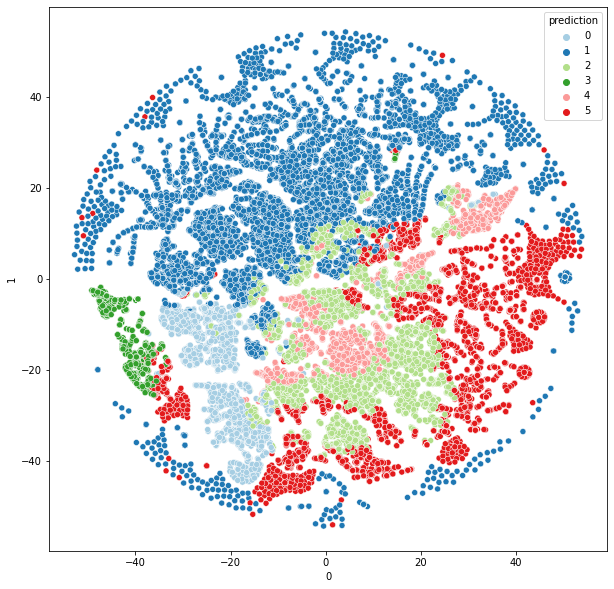

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_2_dim_df[0], y=x_2_dim_df[1], hue=df['prediction'], palette='Paired')
plt.savefig('./cluster_scater.svg')

In [ ]:
import seaborn as sns
df = pd.read_csv('/content/data/cluster_output/5min_6/final_df.csv', index_col=0)

In [ ]:
import statsmodels.api as st

y = df['prediction']
# x = df.drop(['prediction', 'Home', 'Work', 'School', 'Shop/Services',
#              'Organization/Hobbies', 'Exercise',
#              'Entertainment/Recreation', 'Other'
#               , 'income_50,000$ to 100,000$',
#             'income_100,000$ to 150,000', 'income_less than 50000$'], axis=1)

cols =['GENDER', 'J1_TELECOMMUTE','Disabled_person', 
       'AGE_18 and younger', 'AGE_18 to 35', 'AGE_35 to 60',
       'EMPLOYMENT_STATUS_Homemaker', 'EMPLOYMENT_STATUS_Retired',
       'EMPLOYMENT_STATUS_Student (part-time or full-time)',
       'EMPLOYMENT_STATUS_Worker, including self employed',
       'income_less than 50000$']

x = df[cols]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x = st.add_constant(x, prepend = False)
mdl = st.MNLogit(y, x)
mdl_fit = mdl.fit()
results = mdl_fit.summary()
mdl_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 1.203648
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             prediction   No. Observations:                27835
Model:                        MNLogit   Df Residuals:                    27775
Method:                           MLE   Df Model:                           55
Date:                Wed, 25 May 2022   Pseudo R-squ.:                  0.1921
Time:                        09:51:09   Log-Likelihood:                -33504.
converged:                       True   LL-Null:                       -41468.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================================
                                      prediction=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
GENDER                                                -0.3742      0.048     -7.807      0.000      -0.468      -0.280
J1_TELECOMMUTE                                         0.0395      0.053      0.745      0.456      -0.064       0.143
Disabled_person                                        0.2570      0.463      0.555      0.579      -0.651       1.165
AGE_18 and younger                                    -1.4075      0.296     -4.758      0.000      -1.987      -0.828
AGE_18 to 35                                          -0.2079      0.092     -2.263      0.024      -0.388      -0.028
AGE_35 to 60                                          -0.8350      0.081    -10.370      0.000      -0.993      -0.677
EMPLOYMENT_STATUS_Homemaker                           -1.0935      0.617     -1.773      0.076      -2.302       0.115
EMPLOYMENT_STATUS_Retired                             -0.7339      0.208     -3.522      0.000      -1.142      -0.325
EMPLOYMENT_STATUS_Student (part-time or full-time)     1.2443      0.288      4.325      0.000       0.680       1.808
EMPLOYMENT_STATUS_Worker, including self employed      3.1725      0.137     23.128      0.000       2.904       3.441
income_less than 50000$                               -0.0943      0.081     -1.165      0.244      -0.253       0.064
const                                                 -0.4175      0.155     -2.686      0.007      -0.722      -0.113
----------------------------------------------------------------------------------------------------------------------
                                      prediction=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
GENDER                                                -0.0564      0.054     -1.036      0.300      -0.163       0.050
J1_TELECOMMUTE                                        -0.0554      0.066     -0.836      0.403      -0.185       0.074
Disabled_person                                        1.1429      0.263      4.339      0.000       0.627       1.659
AGE_18 and younger                                    -0.4543      0.287     -1.583      0.114      -1.017       0.108
AGE_18 to 35                                          -1.0545      0.101    -10.453      0.000      -1.252      -0.857
AGE_35 to 60                                          -1.4439      0.086    -16.851      0.000      -1.612      -1.276
EMPLOYMENT_STATUS_Homemaker                           -0.4229      0.251     -1.686      0.092      -0.915       0.069
EMPLOYMENT_STATUS_Retired                              0.5115      0.123      4.162      0.000       0.271       0.752
EMPLOYMENT_STATUS_Student (part-time or full-time)     0.1601      0.243      0.659      0.510      -0.316       0.636
EMPLOYMENT_STATUS_Worker, in

In [ ]:
reg_results = results.tables[0].as_html()
coef_results = results.tables[1].as_html()

reg_results = pd.read_html(reg_results, header=0, index_col=0)[0]
coef_results = pd.read_html(coef_results, header=0, index_col=0)[0]

reg_results.to_csv('./reg_results1.csv')
coef_results.to_csv('./logit_coeff1.csv')

In [ ]:
mdl_margeff = mdl_fit.get_margeff()
marg_sum = mdl_margeff.summary()
#mdl_margeff.summary()

In [ ]:
marginal = marg_sum.tables[1].as_html()

marginal = pd.read_html(marginal, header=0, index_col=0)[0]

marginal.to_csv('./marginal_effect1.csv')

In [ ]:
import pandas as pd

df = pd.read_csv('/content/data/cluster_output/5min_6/txt_split_df.csv', index_col=0)
#pd.set_option('display.max.columns', None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.dropna(axis=1, inplace=True)

In [ ]:
def pattern_agg(df):
    #############################################
    value_count_list = list()
    for column in df.columns:
        count = df[column].value_counts().to_frame().rename(columns={'0': column})
        value_count_list.append(count)

    init_df = value_count_list[0]
    for column in value_count_list[1:]:
        init_df = init_df.join(column)
    df_agg = init_df.drop('prediction', axis=1).fillna(0)
    ##############################################
    hour = 0
    list_hourly = list()
    for i in range(24):
        df_hourly = df_agg[str(hour+0)]+df_agg[str(hour+1)]+df_agg[str(hour+2)]+ \
        df_agg[str(hour+3)]+df_agg[str(hour+4)]+df_agg[str(hour+5)]+ \
        df_agg[str(hour+6)]+df_agg[str(hour+7)]+df_agg[str(hour+8)]+ \
        df_agg[str(hour+9)]+df_agg[str(hour+10)]+df_agg[str(hour+11)]
        hour = hour + 11
        df_hourly = df_hourly.to_frame().rename(columns={0:i})
        list_hourly.append(df_hourly)

    init_hourly = list_hourly[0]
    for column in list_hourly[1:]:
        init_hourly = init_hourly.join(column)
    ############################################    
    half_hour = 0
    list_half_hourly = list()
    for i in range(48):
        df_half_hourly = df_agg[str(half_hour+0)]+df_agg[str(half_hour+1)]+df_agg[str(half_hour+2)]+ \
        df_agg[str(half_hour+3)]+df_agg[str(half_hour+4)]+df_agg[str(half_hour+5)]
        half_hour = half_hour + 5
        df_half_hourly = df_half_hourly.to_frame().rename(columns={0:i})
        list_half_hourly.append(df_half_hourly)

    init_half_hourly = list_half_hourly[0]
    for column in list_half_hourly[1:]:
        init_half_hourly = init_half_hourly.join(column)

    return init_half_hourly, init_hourly, df_agg

In [ ]:
df.prediction.unique()

array([1, 2, 5, 4, 0, 3])

In [ ]:
empty_df = pd.DataFrame()
n=0
for i in df.prediction.unique():
  try:
    df_cluster = df[df['prediction']==i]
    df_half_hour_agg, df_hour_agg, df_5min_agg = pattern_agg(df_cluster)

    df_hour_agg['cluster']=i
    df_half_hour_agg['cluster']=i
    df_5min_agg['cluster']=i

    if n==0:
        df_hour_cluster = df_hour_agg.copy()
        df_half_hour_cluster = df_half_hour_agg.copy()
        df_5min_cluster = df_5min_agg.copy()
    else:
        df_hour_cluster = pd.concat([df_hour_cluster, df_hour_agg])
        df_half_hour_cluster = pd.concat([df_half_hour_cluster, df_half_hour_agg])
        df_5min_cluster = pd.concat([df_5min_cluster, df_5min_agg])
    n+=1
  except:
    pass

df_hour_cluster.to_excel('hourly_pattern_agg_cluster.xlsx')
df_half_hour_cluster.to_excel('half_hourly_pattern_agg_cluster.xlsx')
df_5min_cluster.to_excel('5min_pattern_agg_cluster.xlsx')

In [ ]:
df_half_hour_agg, df_hour_agg, df_5min_agg = pattern_agg(df)

df_hour_agg.to_excel('hourly_pattern_agg.xlsx')
df_half_hour_agg.to_excel('half_hourly_pattern_agg.xlsx')
df_5min_agg.to_excel('5min_pattern_agg.xlsx')

In [ ]:
df_5min_cluster

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,cluster
home,12383,12387.0,12389.0,12389.0,12393.0,12398.0,12398.0,12404.0,12410.0,12415.0,...,12177.0,12210.0,12230.0,12272.0,12288.0,12306.0,12327.0,12342.0,12355.0,1
driving,43,49.0,42.0,42.0,40.0,39.0,33.0,34.0,27.0,21.0,...,139.0,133.0,123.0,84.0,109.0,100.0,79.0,80.0,78.0,1
work,6,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,71.0,57.0,50.0,48.0,22.0,15.0,14.0,8.0,3.0,1
socialize,4,0.0,3.0,1.0,5.0,2.0,5.0,4.0,4.0,5.0,...,20.0,19.0,18.0,15.0,10.0,8.0,11.0,3.0,2.0,1
meal,2,1.0,3.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,11.0,6.0,6.0,7.0,4.0,5.0,3.0,3.0,3.0,1
otheractivities,1,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1
gas,1,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1
dropofforpick,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
recreation,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
entertainment,1,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,13.0,10.0,8.0,6.0,4.0,3.0,1.0,0.0,1


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,prediction
0,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,1
1,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,1
2,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,1
3,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,2
4,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27830,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,2
27831,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,5
27832,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,2
27833,home,home,home,home,home,home,home,home,home,home,...,home,home,home,home,home,home,home,home,home,5
